# Introduction

Import Libraries

In [1]:
import urllib.request
from urllib.request import urlopen

import sys
import spotipy
import spotipy.util as util
import os
import json
import webbrowser
from json.decoder import JSONDecodeError

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from numpy import arange,array,ones
import matplotlib.pyplot as plt

import seaborn as sns
# Set font scale
sns.set(font_scale=1.5)

import itertools

In [3]:
from scipy import optimize

In [4]:
from scipy.optimize import minimize

In [5]:
from gekko import gekko

Expand Screen

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [7]:
import json
with urlopen('https://raw.githubusercontent.com/dqa611/Spotify_DJ/master/anhquocduong611_Anjunadeep_playlist_data.json') as f:
    playlist_data = json.load(f)

# Bobdy Script

### Calculate Total Duration of the Playlist

In [8]:
def convert_ms(milli):
    seconds=round((milli/1000)%60,2)
    minutes=round((milli/(1000*60))%60,2)
    hours=round((milli/(1000*60*60))%24,2)
    
    hour_read = str(int(hours))+':'+str(int(minutes))
    minute_read = int(hours)*60 + int(minutes)
    return hour_read, minute_read

In [9]:
playlist_duration_ms = 0
for i in range(len(playlist_data)):
    playlist_duration_ms += playlist_data[i]['duration_ms']

    playlist_duration = convert_ms(playlist_duration_ms)

print(playlist_duration)

('3:19', 199)


### Get Summary Statistics about the Playlist

In [10]:
audio_data_point = ['track_name', 'duration_ms', 'popularity', 'danceability', 
                    'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo',]

playlist_stats = dict.fromkeys(audio_data_point)

for data_point in audio_data_point:
    audio_stats = []
    for i in range(len(playlist_data)):
        audio_stats.append(playlist_data[i][data_point])
        playlist_stats[data_point] = audio_stats

In [11]:
data_point_plot = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo']
data_point_comb = list(itertools.combinations(data_point_plot, r=2))

#### More information about the data points

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Playlist Data Point Distribution

Green line is average line
Red line is median line


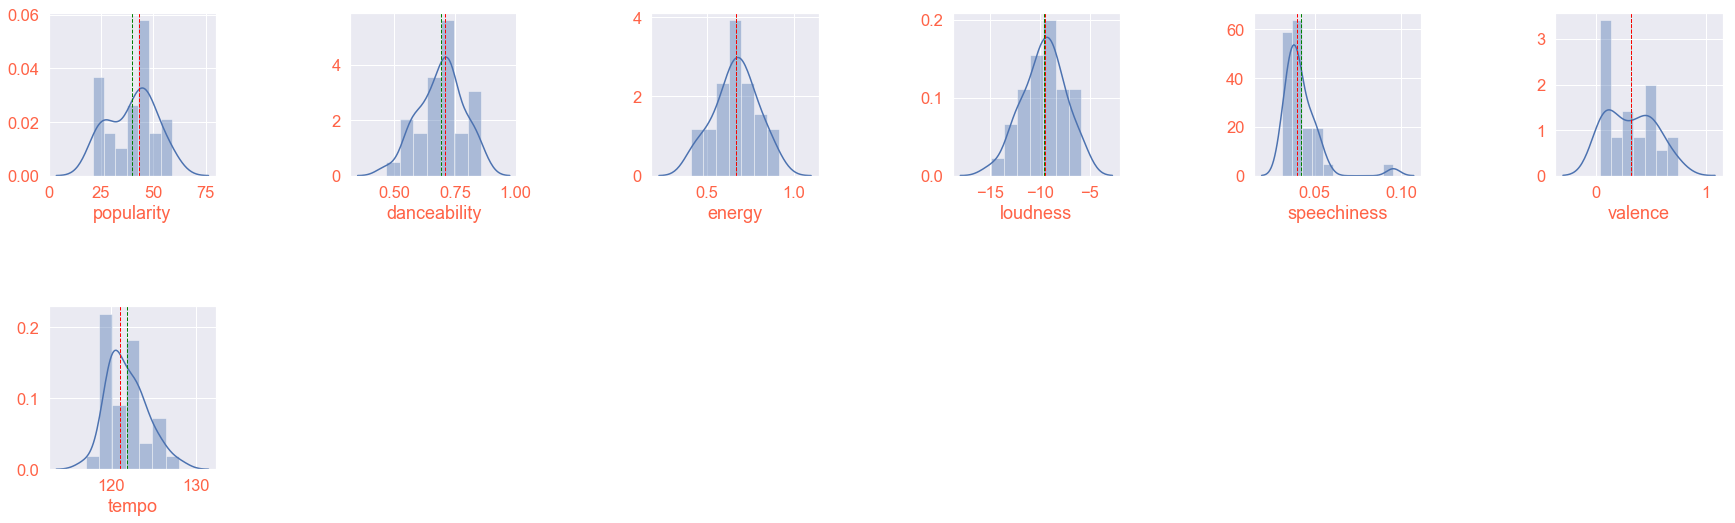

In [12]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

print('Green line is average line')
print('Red line is median line')

for i in range(len(data_point_plot)):
    
    ax = fig.add_subplot(6,6,i+1)
    ax = sns.distplot(playlist_stats[data_point_plot[i]], bins='auto')
    
    # Draw average line
    ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).mean().item(), color='green', linestyle='dashed', linewidth=1)
    # Draw median line
    ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).median().item(), color='red', linestyle='dashed', linewidth=1)
    
    ax.set_xlabel(data_point_plot[i], color='tomato')
    ax.tick_params(axis='x', colors='tomato')
    ax.tick_params(axis='y', colors='tomato')

Writer's opinion: a homogeneous playlist will have normal distributions among Data Points

### Correlation Between Data Points in the Playlist

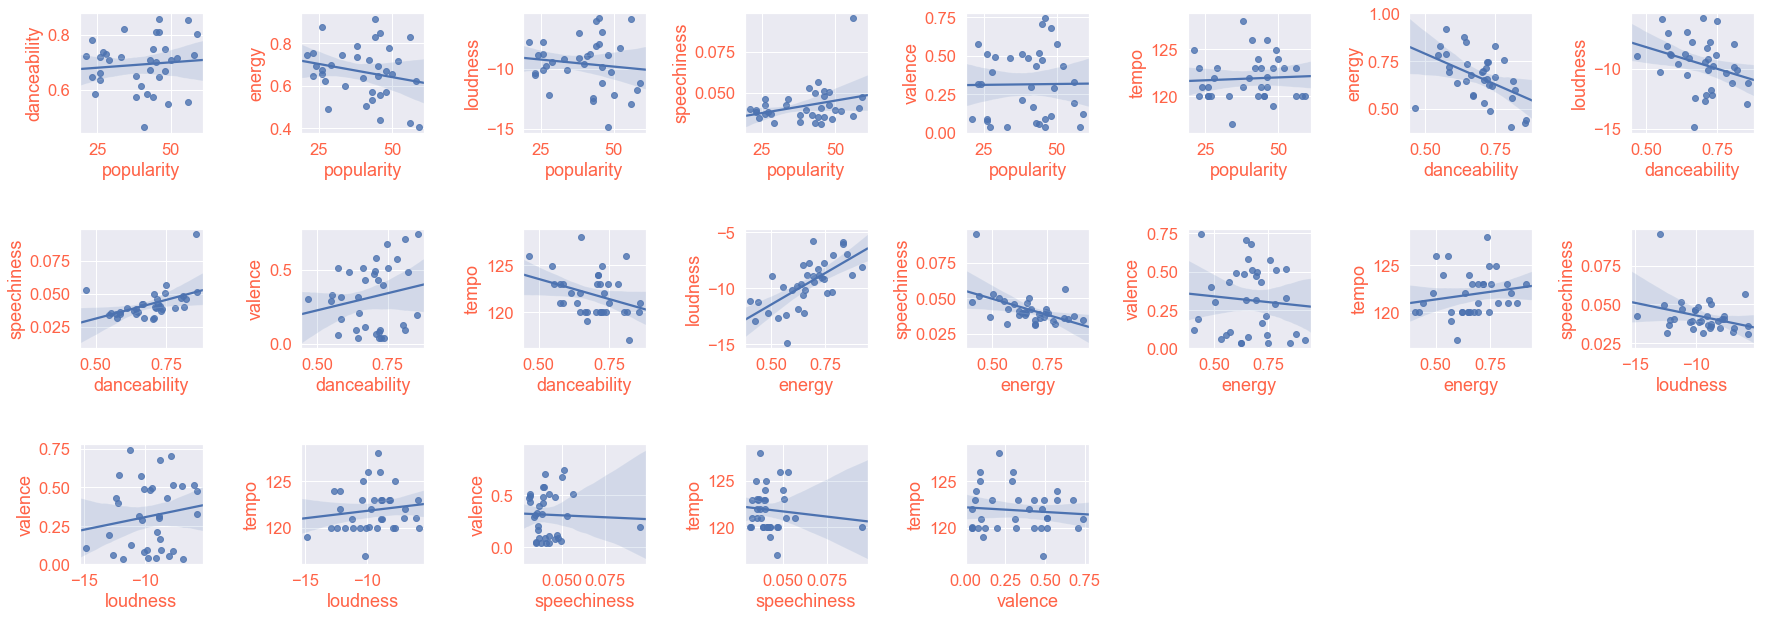

In [13]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for i in range(len(data_point_comb)):
    ax = fig.add_subplot(8,8,i+1)
    ax = sns.regplot(playlist_stats[data_point_comb[i][0]], playlist_stats[data_point_comb[i][1]])
    ax.set_xlabel(data_point_comb[i][0], color='tomato')
    ax.set_ylabel(data_point_comb[i][1], color='tomato')
    ax.tick_params(axis='x', colors='tomato')
    ax.tick_params(axis='y', colors='tomato')

### Plot a Track by Sections

In [14]:
playlist_data[0]['sections'][0].keys()

dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])

###### Convert duration from seconds to minute

In [15]:
for i in range(len(playlist_data)):
    for z in range(len(playlist_data[i]['sections'])):
        playlist_data[i]['sections'][z]['start_minute'] = playlist_data[i]['sections'][z]['start']/60

In [16]:
track_metrics = ['start_minute', 'loudness', 'tempo', 'mode']
track_metrics_dict = dict.fromkeys(track_metrics, 0)
all_tracks_sections = []

track_metrics_dict1 = track_metrics_dict.copy()

for x in range(len(playlist_data)):
    track_metrics_dict1['track_name'] = playlist_data[x]['track_name']
    track_metrics_dict1['track_id'] = playlist_data[x]['track_id']
    track_metrics_dict1['artist'] = playlist_data[x]['artist']
    track_metrics_dict1['album'] = playlist_data[x]['album']
    # For each metric
    for y in track_metrics:
        # Reset the list that collects data point 
        track_sections_data = []        
        # For each metric, loop by the number of sections in the track
        for z in range(len(playlist_data[x]['sections'])):
            # Add data point to a list
            track_sections_data.append(playlist_data[x]['sections'][z][y])
            # Add the list to a dict of track data points
            track_metrics_dict1[y] = track_sections_data
    # Add the dict to a list of tracks
    all_tracks_sections.append(track_metrics_dict1.copy())

###### Function to plot a Track

In [17]:
def plot_track(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
    
    fig = plt.figure(figsize=(5,3))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    # Plot title by Track name and Artist
    fig.suptitle(all_tracks_sections[track_index]['track_name'] + ' -- ' + all_tracks_sections[track_index]['artist'], color='tomato', fontsize=20)

    for key, value in enumerate(track_metrics[1:3]):
        ax = fig.add_subplot(2,1,key+1)
        ax = sns.lineplot(all_tracks_sections[track_index]['start_minute'], all_tracks_sections[track_index][value])
        ax.set_ylabel(value, color='tomato', fontsize=18)
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
        # Plot average line
        ax.axhline(np.mean(all_tracks_sections[track_index][value]), color='green', linestyle='dashed', linewidth=1)
        # Plot Section breakout line
        for i in range(len(all_tracks_sections[track_index]['start_minute'])):
            ax.axvline(all_tracks_sections[track_index]['start_minute'][i], color='purple', linestyle='dashed', linewidth=1)

    ax.set_xlabel('time', color='tomato')
    # ax.text(1, 1, 'Green line is Average \n Purple line is Section', transform=ax.transAxes, fontsize=14,verticalalignment='bottom', color='tomato')

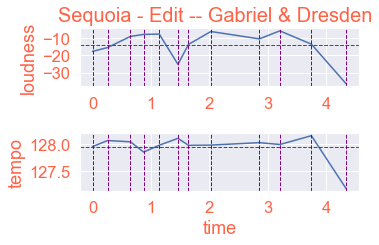

In [18]:
plot_track('7grW4FTwEzN67X01lUiAAx')

# Mix a DJ Set

first is identify intro and outtro song

find track with slow tempo and loudness at the first section. 

find track with highest difference 

##### First is find track with same tempo

to find that we're going to omit the beginning and ending of a track

In [19]:
for i in range(len(playlist_data)):
    # Duration of 1st Section
    playlist_data[i]['duration_1st_section'] = playlist_data[i]['sections'][0]['duration']
    # Duration of last Section
    playlist_data[i]['duration_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['duration']
   
    # Tempo of 1st Section
    playlist_data[i]['tempo_1st_section'] = playlist_data[i]['sections'][0]['tempo']
    # Tempo of last Section
    playlist_data[i]['tempo_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['tempo']  
    
    # Key of 1st Section
    playlist_data[i]['key_1st_section'] = playlist_data[i]['sections'][0]['key']
    # Key of last Section
    playlist_data[i]['key_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['key']   
    
    # Modality of 1st Section
    playlist_data[i]['modality_1st_section'] = playlist_data[i]['sections'][0]['mode']
    # Modality of last Section
    playlist_data[i]['modality_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['mode']
   
    # Tempo of 2nd Section
    playlist_data[i]['tempo_2nd_section'] = playlist_data[i]['sections'][1]['tempo']
    # Tempo of 2nd last Section
    playlist_data[i]['tempo_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['tempo']  
    
    # Key of 2nd Section
    playlist_data[i]['key_2nd_section'] = playlist_data[i]['sections'][1]['key']
    # Key of 2nd last Section
    playlist_data[i]['key_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['key']     
    
    # Modality of 2nd Section
    playlist_data[i]['modality_2nd_section'] = playlist_data[i]['sections'][1]['mode']
    # Modality of 2nd last Section
    playlist_data[i]['modality_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['mode']
    
    # Loudness of 2nd Section
    playlist_data[i]['loudness_2nd_section'] = playlist_data[i]['sections'][1]['loudness']
    # Loudness of 2nd last Section
    playlist_data[i]['loudness_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['loudness']

So the goal is the ending of the previous track last second will end at the end of the first section of the next track plus 1 second

In [20]:
track_transition_data = ['duration_1st_section','duration_1st_section','duration_1st_section','duration_1st_section','tempo_1st_section','tempo_last_section',
                        'key_1st_section','key_last_section','modality_1st_section','modality_last_section','loudness_1st_section','loudness_last_section',
                        'tempo_2nd_section','tempo_2ndlast_section','key_2nd_section','key_2ndlast_section','loudness_2nd_section','loudness_2ndlast_section']

In [21]:
previous_track = playlist_data[0]
previous_track_sections = previous_track['sections']

next_track = playlist_data[1]
next_track_sections = next_track['sections']

In [22]:
def track_playlist_index(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
            return track_index
            break
    print('Not Found')

### Optimization: Find the Next Track with the most similar Tempo

###### Select how to connect 2 tracks. 2 Ideas:

(1) The last section of the previous track should be as close as the beginning section of the next track

(2) The second last section of the previous track, which usually the chorus/ drop/ highlight of the track, should match the 2nd section of the next track, since the last and beginning section of a track are usually intro and outtro with minimal sound

### Camelot Harmony Key System

In [25]:
def track_keys_input(key_input, mode_input):
    track_keys = dict.fromkeys(['key', 'mode'])
    track_keys.update(key=key_input)
    track_keys.update(mode=mode_input)
    return track_keys

In [26]:
def camelot_system(track_keys):
    track_keys_harmony1 = track_keys.copy()
    track_keys_harmony2 = track_keys.copy()
    track_keys_harmony3 = track_keys.copy()

    if track_keys['mode'] == 1:
        # Go up one key, same modality
        if track_keys['key']+1==13:
            track_keys_harmony1['key'] = 1
        else:
            track_keys_harmony1['key'] = track_keys['key']+1
        track_keys_harmony1['mode'] = track_keys['mode']

        # Go down one key, same modality
        if track_keys['key']-1==0:
            track_keys_harmony2['key'] = 12
        else:
            track_keys_harmony2['key'] = track_keys['key']-1
        track_keys_harmony2['mode'] = track_keys['mode']

        # Same key, change modality
        track_keys_harmony3['key'] = track_keys['key']
        track_keys_harmony3['mode'] = abs(track_keys['mode']-1)

    if track_keys['mode'] == 0:
        # Change modality
        track_keys_harmony1['key'] = track_keys['key']
        track_keys_harmony1['mode'] = abs(track_keys['mode']-1)

        # Go down one key, change modality
        if track_keys['key']+1==13:
            track_keys_harmony2['key'] = 1
        else:
            track_keys_harmony2['key'] = track_keys['key']+1
        track_keys_harmony2['mode'] = abs(track_keys['mode']-1)
    
        # Go up one key, change modality
        if track_keys['key']-1==0:
            track_keys_harmony3['key'] = 12
        else:
            track_keys_harmony3['key'] = track_keys['key']-1
        track_keys_harmony3['mode'] = abs(track_keys['mode']-1)
        
    return track_keys, track_keys_harmony1, track_keys_harmony2, track_keys_harmony3

In [27]:
previous_track_tempo_select = 'tempo_last_section'
next_track_tempo_select = 'tempo_2nd_section'

In [50]:
playlist_data[0]['key']

5

In [49]:
playlist_data[int(list(index.value)[0])]

{'track_name': 'Heartbeat (feat. Nathan Nicholson)',
 'artist': 'Claptone',
 'album': 'Charmer',
 'track_id': '2uGWFmJYpJMUNhzG1Zg6LN',
 'popularity': 45,
 'danceability': 0.812,
 'energy': 0.648,
 'key': 10,
 'loudness': -7.916,
 'mode': 0,
 'speechiness': 0.0405,
 'acousticness': 0.0177,
 'instrumentalness': 0.311,
 'liveness': 0.0829,
 'valence': 0.707,
 'tempo': 120.006,
 'type': 'audio_features',
 'id': '2uGWFmJYpJMUNhzG1Zg6LN',
 'uri': 'spotify:track:2uGWFmJYpJMUNhzG1Zg6LN',
 'track_href': 'https://api.spotify.com/v1/tracks/2uGWFmJYpJMUNhzG1Zg6LN',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2uGWFmJYpJMUNhzG1Zg6LN',
 'duration_ms': 329538,
 'time_signature': 4,
 'sections': [{'start': 0.0,
   'duration': 16.50342,
   'confidence': 1.0,
   'loudness': -11.837,
   'tempo': 119.969,
   'tempo_confidence': 0.924,
   'key': 10,
   'key_confidence': 0.116,
   'mode': 0,
   'mode_confidence': 0.671,
   'time_signature': 4,
   'time_signature_confidence': 1.0,
   'start_m

In [51]:
m=gekko()

index = m.Var(0,lb=0,ub=len(playlist_data),integer=True)
tempo_change = m.Var()
key_match = m.Var()

index_insert = list(index.value)[0]
next_track = playlist_data[index_insert]
next_track_key = {'key': next_track['key'], 'mode': next_track['mode']}
next_track_tempo = playlist_data[index_insert][next_track_tempo_select]

# The equation that will be optimized
m.Equation(tempo_change==previous_track[previous_track_tempo_select]-next_track_tempo)

# Constraint
m.Equation(key_match==int(next_track_key in camelot_system(track_keys_input(previous_track['key'], previous_track['mode'])))) 
m.Equation(key_match==1)

# Objective is minimize tempo change and maximize key match. Key match == 1 means the next track key matches harmony
m.Obj(-tempo_change)

m.options.IMODE=3

m.solve()

print('Previous Track Name: ')
print('    '+str(previous_track['track_name']))
print('Previous Track Tempo:')
print('    '+str(previous_track['tempo_last_section']))
print('Next Track Tempo: ')
print('    '+str(next_track_tempo))
print('Previous Track Key: ')
print('    '+str({'key': previous_track['key'], 'mode': previous_track['mode']}))
print('Index Value: ')
print('    '+str(int(index.value[0])))
print('Tempo Change: ')
print('    '+str(tempo_change.value[0]))
print('Next Track Key: ')
print('    '+str(next_track_key))
print('Next Track Name: ')
print('    '+str(playlist_data[int(index.value[0])]['track_name']))

apm 67.254.215.117_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            3
   Intermediates:            0
   Connections  :            0
   Equations    :            4
   Residuals    :            4
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program co